In [1]:
import warnings
warnings.simplefilter("ignore")
from yahoofinancials import YahooFinancials
import yfinance as yf
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num
import squarify
import datetime
import random
from datetime import date
import datetime as DT
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time

In [2]:
# Get today's date as UTC timestamp
today = datetime.today().strftime("%d/%m/%Y")
today = datetime.strptime(today + " +0000", "%d/%m/%Y %z")
to = int(today.timestamp())
# Get date 1 year ago as UTC timestamp
begin =datetime(2021, 1, 1, 1, 1, 1)
fro = int(begin.timestamp())

In [20]:
def get_price_hist(ticker):

    # Put stock price data in dataframe
    url = "https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={fro}&period2={to}&interval=1d&events=history".format(ticker=ticker, fro=fro, to=to)
    data = pd.read_csv(url)
    
    # Convert date to timestamp and make index
    data.index = data["Date"].apply(lambda x: pd.Timestamp(x))
    data.drop("Date", axis=1, inplace=True)

    return data

In [21]:
column_names = ['firm','marketcap','totalmkt','percentage', 'YTD']
df = pd.DataFrame(columns = column_names)
firms = pd.read_csv('stuff.csv')
ytd='NaN'

In [22]:
i=0
totalmkt = 0
for index, row in firms.iterrows():
    a=random.randint(5,10)
    time.sleep(a)
    firm=row['firm']
    firm=firm.rstrip().lstrip()
    
    df.loc[i, ['firm']]= firm
    
    yahoo_financials = YahooFinancials(firm)
       
    try:
        marketcap=yahoo_financials.get_market_cap()
        df.loc[i, ['marketcap']]=marketcap
    except:
        df.loc[i, ['marketcap']]='NaN'
    
    try: 
        if i==0:
            i=i+1
            totalmkt=totalmkt + df.loc[i-1, ['marketcap']][0]
            df.loc[i-1, ['totalmkt']]=totalmkt
        elif i>0:
            totalmkt=totalmkt + df.loc[i, ['marketcap']][0]
            df.loc[i, ['totalmkt']]=totalmkt
    except:
        totalmkt=totalmkt + 0
        df.loc[i, ['totalmkt']]=totalmkt
        print('This firm market cap data is missing :   ', firm)
        

    #calling function get_price_hist to calculate YTD return
    time.sleep(a)
    if i==1:
        try:
            ticker_df=get_price_hist(firm)
            ytd=(ticker_df['Close'].iloc[-1] / ticker_df['Close'].iloc[0]  -1) * 100 #calculate YTD return %
            df.loc[i-1, ['YTD']]=ytd
        except:
            df.loc[i-1, ['YTD']]='NaN'
    elif i>1:
        try:
            ticker_df=get_price_hist(firm)
            ytd=(ticker_df['Close'].iloc[-1] / ticker_df['Close'].iloc[0]  -1) * 100 #calculate YTD return %
            df.loc[i, ['YTD']]=ytd
        except:
            df.loc[i, ['YTD']]='NaN'
    
    print(i, ' ', firm, ' marketcap ', marketcap, ' acumulative market cap ',  totalmkt, ' ytd ', ytd )
    

    
    i=i+1
    
df[['percentage']]= df[['marketcap']] / df[['totalmkt']].iloc[-1][0]

1   IBM  marketcap  115061219328  acumulative market cap  115061219328  ytd  6.279471021762473
2   IP  marketcap  17926404096  acumulative market cap  132987623424  ytd  2.376899449808545
3   IPG  marketcap  14454746112  acumulative market cap  147442369536  ytd  58.254107962580306
4   IFF  marketcap  36820221952  acumulative market cap  184262591488  ytd  38.85611079451634
5   INTU  marketcap  176452698112  acumulative market cap  360715289600  ytd  70.55690113886786
6   ISRG  marketcap  122235789312  acumulative market cap  482951078912  ytd  25.448754642950178
7   IVZ  marketcap  10441725952  acumulative market cap  493392804864  ytd  33.98228708069102
8   IPGP  marketcap  8926042112  acumulative market cap  502318846976  ytd  -24.302283258714162
9   IQV  marketcap  51345817600  acumulative market cap  553664664576  ytd  50.87769136315885
10   IRM  marketcap  14891557888  acumulative market cap  568556222464  ytd  76.90160851360781
11   JKHY  marketcap  12136060928  acumulative mark

In [23]:
# !!!!!!!!!!!!!!!!!do NOT run this line more than once  !!!!!!!!!!!!!!!!!!!!
#df.to_csv('sp500mktcap.csv')

In [3]:
df=pd.read_csv('sp500mktcap.csv')
pd.set_option('display.max_rows',600)
df = df[df['YTD'].notna()]
df['firmmarketcap0']= df['marketcap']/(1+df['YTD']/100)
df['totalmkt0']=df['firmmarketcap0'].cumsum()
df['sharemarketcap0']= (df['firmmarketcap0']/df[['totalmkt0']].iloc[-1][0])*100
deltamkt = df[['totalmkt']].iloc[-1][0]- df[['totalmkt0']].iloc[-1][0]
df['contribu2sp500']= df['firmmarketcap0'] * df['YTD'] * 1 / deltamkt
df['sp500ytd']=(df[['totalmkt']].iloc[-1][0]/ df[['totalmkt0']].iloc[-1][0] - 1 ) * 100
df.sort_values('contribu2sp500', ascending=False, inplace=True)

8
7


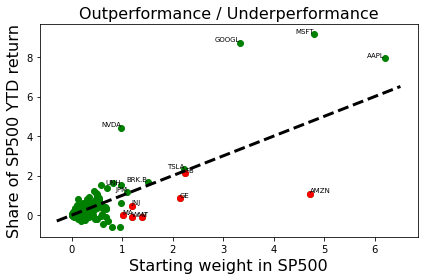

In [4]:
# scatter plot with matplotlib in Python
plt.scatter(df.sharemarketcap0, df.contribu2sp500, alpha=1, s=0.01)
# set x-axis label and specific size
plt.xlabel('Starting weight in SP500',size=16)
# set y-axis label and specific size
plt.ylabel('Share of SP500 YTD return',size=16)
# set plot title with specific size
plt.title('Outperformance / Underperformance',size=16)
#draw 45% line
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

#overperforming
df2 = df.query('sharemarketcap0  >=0.9 & YTD >=sp500ytd')
graph=plt.scatter(df.sharemarketcap0, df.contribu2sp500, color="green")


#overperforming
df3 = df.query('sharemarketcap0  >=1 & YTD < sp500ytd')
graph=plt.scatter(df3.sharemarketcap0, df3.contribu2sp500, color="red")

# loop through to annotate multiple datapoints
for i in range(df2.shape[0]):
    plt.annotate(df2.firm.tolist()[i], (df2.sharemarketcap0.tolist()[i], df2.contribu2sp500.tolist()[i]), fontsize=7, color="black", ha='right', va='bottom')
print(df2.shape[0])
plt.tight_layout()

# loop through to annotate multiple datapoints
for i in range(df3.shape[0]):
    plt.annotate(df3.firm.tolist()[i], (df3.sharemarketcap0.tolist()[i], df3.contribu2sp500.tolist()[i]), fontsize=7, color="black",ha='left', va='bottom')
print(df3.shape[0])
plt.tight_layout()

# save the plot as PNG file with dpi=150
plt.savefig('Outperformance_Underperforming.png', dpi=600)

31


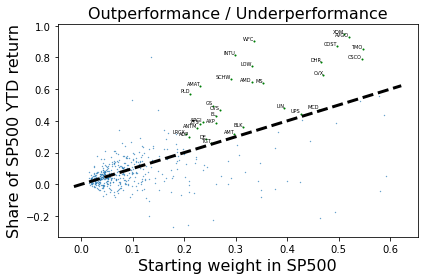

In [17]:
df2 = df.query('sharemarketcap0  <0.6 & contribu2sp500 <1')
# scatter plot with matplotlib in Python
plt.scatter(df2.sharemarketcap0, df2.contribu2sp500, alpha=1, s=0.1)
# set x-axis label and specific size
plt.xlabel('Starting weight in SP500',size=16)
# set y-axis label and specific size
plt.ylabel('Share of SP500 YTD return',size=16)
# set plot title with specific size
plt.title('Outperformance / Underperformance',size=16)
#draw 45% line
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

#overperforming
df2 = df2.query('sharemarketcap0  >0.2 & YTD >=sp500ytd')
graph=plt.scatter(df2.sharemarketcap0, df2.contribu2sp500, color="green", s=1)

# loop through to annotate multiple datapoints
for i in range(df2.shape[0]):
    plt.annotate(df2.firm.tolist()[i], (df2.sharemarketcap0.tolist()[i], df2.contribu2sp500.tolist()[i]), fontsize=5, color="black", ha='right', va='bottom')
print(df2.shape[0])
plt.tight_layout()

# save the plot as PNG file with dpi=150
plt.savefig('Outperformance_Underperforming.png', dpi=600)

41


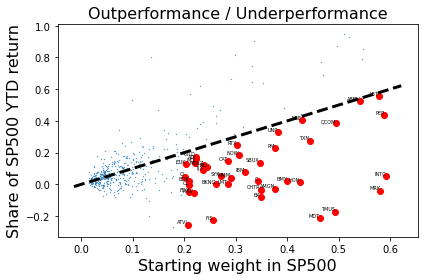

In [159]:
df2 = df.query('sharemarketcap0  <0.6 & contribu2sp500 <1')
# scatter plot with matplotlib in Python
plt.scatter(df2.sharemarketcap0, df2.contribu2sp500, alpha=1, s=0.1)
# set x-axis label and specific size
plt.xlabel('Starting weight in SP500',size=16)
# set y-axis label and specific size
plt.ylabel('Share of SP500 YTD return',size=16)
# set plot title with specific size
plt.title('Outperformance / Underperformance',size=16)
#draw 45% line
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

#overperforming
df2 = df2.query('sharemarketcap0  >0.2 & YTD < sp500ytd')
graph=plt.scatter(df2.sharemarketcap0, df2.contribu2sp500, color="red")

# loop through to annotate multiple datapoints
for i in range(df2.shape[0]):
    plt.annotate(df2.firm.tolist()[i], (df2.sharemarketcap0.tolist()[i], df2.contribu2sp500.tolist()[i]), fontsize=5, color="black", ha='right', va='bottom')
print(df2.shape[0])
plt.tight_layout()

# save the plot as PNG file with dpi=150
plt.savefig('Outperformance_Underperforming.png', dpi=1000)

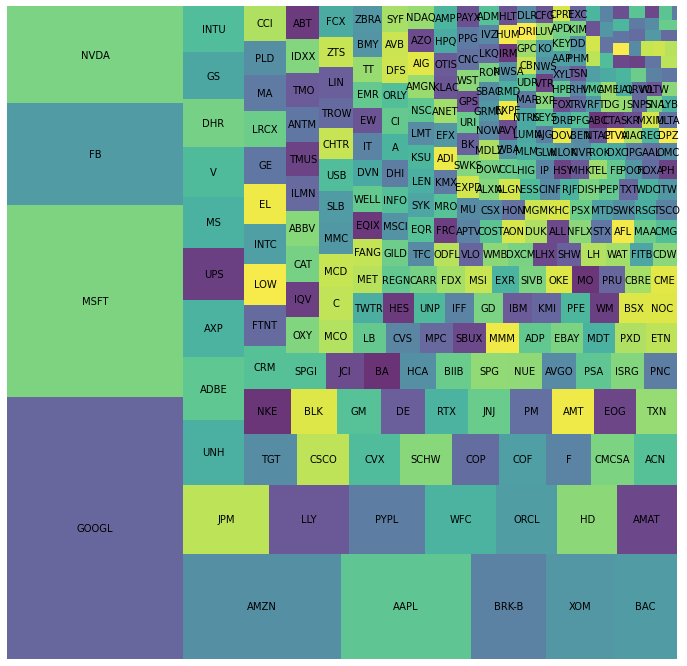

In [58]:
fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=df['contribu2sp500'], 
              label=df['firm'][:300], 
              alpha=.8 )
plt.axis('off')
plt.show()

In [59]:
df.sort_values('YTD', ascending=False, inplace=True)

,firm,marketcap,totalmkt,percentage,YTD,contribu2sp500
296,MRO,1.019082e+10,3.920000e+13,0.000260,93.411420,0.024287
141,FANG,1.593050e+10,3.920000e+13,0.000406,86.289334,0.035033
276,LB,2.000032e+10,3.920000e+13,0.000510,85.555572,0.043633
344,NUE,2.863447e+10,3.920000e+13,0.000730,76.252155,0.055664
348,OXY,2.751719e+10,3.920000e+13,0.000701,74.842397,0.052465
139,DVN,1.863506e+10,3.920000e+13,0.000475,72.597655,0.034484
197,FTNT,4.137335e+10,3.920000e+13,0.001054,72.540531,0.076458
196,F,5.680103e+10,3.920000e+13,0.001448,70.187793,0.101632
204,GPS,1.184915e+10,3.920000e+13,0.000302,68.002095,0.020537
167,EOG,4.732453e+10,3.920000e+13,0.001206,67.910147,0.081900


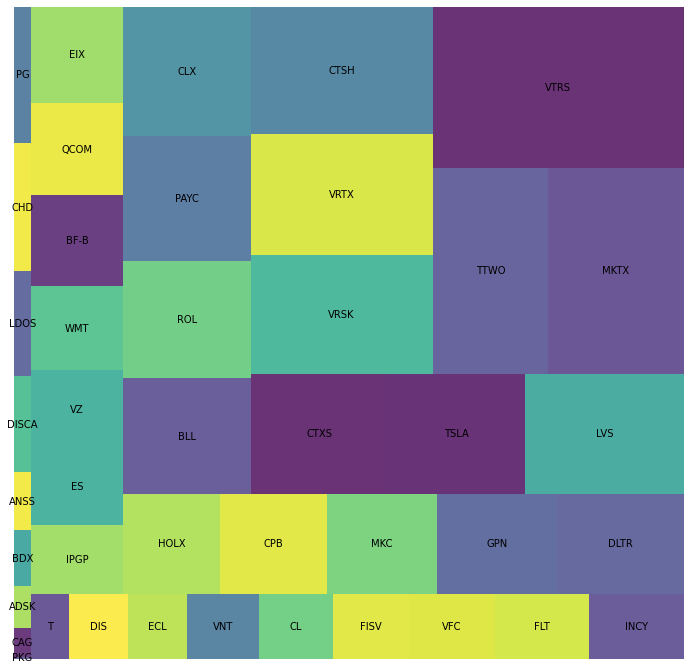

In [61]:
df=df[df.YTD <0]
fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=df['YTD'], 
              label=df['firm'][:300], 
              alpha=.8 )
plt.axis('off')
plt.show()

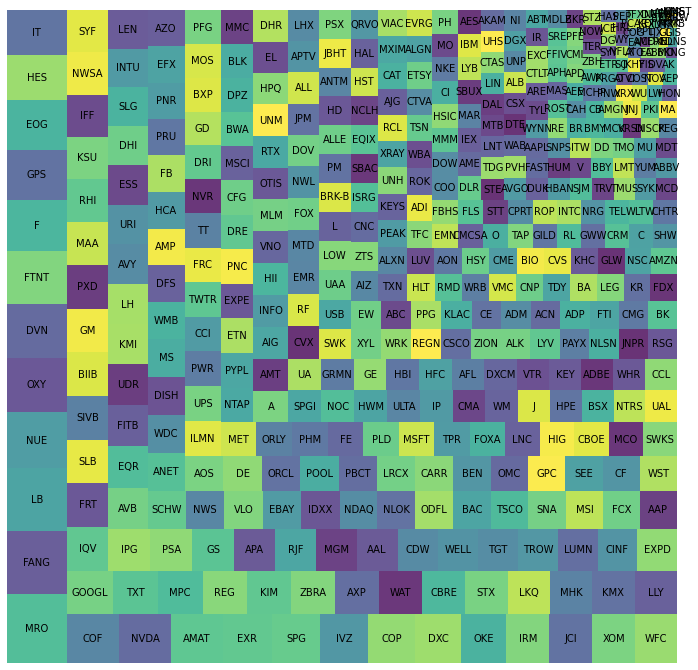

In [66]:
df=df[df.YTD >0]
df.sort_values('YTD', ascending=False, inplace=True)
fig, ax = plt.subplots(1, figsize = (12,12))
squarify.plot(sizes=df['YTD'], 
              label=df['firm'][:500], 
              alpha=.8 )
plt.axis('off')
plt.show()